# Proyek Klasifikasi Gambar: Flower Classification
- **Nama:** Hafizha Aghnia Hasya
- **Email:** hafizhaaghnia24@mail.com
- **ID Dicoding:** 	MC006D5X2114

## Import Semua Packages/Library yang Digunakan

In [28]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import Model, layers, callbacks
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import gc

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hafizhaaghnia","key":"6eeaa888f1cc8373ae2718c9a8ee1316"}'}

In [4]:
# Download kaggle dataset and unzip the file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!rm -rf flower-classification/
!kaggle datasets download -d marquis03/flower-classification
!unzip flower-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/iris/17858672081_4b4d071116_c.jpg  
  inflating: train/iris/17885928250_451875aec2_c.jpg  
  inflating: train/iris/17948299355_2161a031db_c.jpg  
  inflating: train/iris/17959086836_3e706d918b_c.jpg  
  inflating: train/iris/18054931376_23052f68d0_c.jpg  
  inflating: train/iris/18059533553_186ccb451a_c.jpg  
  inflating: train/iris/18076633321_400ea17b5a_c.jpg  
  inflating: train/iris/18120244292_ea11fcc9c5_c.jpg  
  inflating: train/iris/181379030_afebe26851_c.jpg  
  inflating: train/iris/18141122602_118114762d_c.jpg  
  inflating: train/iris/18256508742_af6a8f4222_c.jpg  
  inflating: train/iris/18280071332_c6bc90d75a_c.jpg  
  inflating: train/iris/18348714266_33a7bf205f_c.jpg  
  inflating: train/iris/18504796248_9548f45757_c.jpg  
  inflating: train/iris/18519018712_9ae5d4be08_c.jpg  
  inflating: train/iris/18551525352_70323e50e0_c.jpg  
  inflating: train/iris/18607022104_4ae51cd825_c.jpg  
  inflating: tra

In [5]:
# menghapus file yang tidak digunakan

os.remove('classname.txt')
os.remove('flower-classification.zip')
os.remove('train.csv')
os.remove('val.csv')
os.remove('train/classname.txt')
os.remove('val/classname.txt')

In [6]:
# menggabungkan data dari folder train dan val

# Direktori awal untuk train dan val
train_dir = "train"
val_dir = "val"

# Direktori baru untuk dataset gabungan
combined_dir = "dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Fungsi untuk salin file dari source ke target
def copy_data(source_dir, target_dir):
    for category in os.listdir(source_dir):
        category_path = os.path.join(source_dir, category)
        if os.path.isdir(category_path):
            target_category_path = os.path.join(target_dir, category)
            os.makedirs(target_category_path, exist_ok=True)
            for filename in os.listdir(category_path):
                src_file = os.path.join(category_path, filename)
                dst_file = os.path.join(target_category_path, filename)

                # Cek kalau file dengan nama yang sama sudah ada
                if os.path.exists(dst_file):
                    name, ext = os.path.splitext(filename)
                    counter = 1
                    # Bikin nama baru sampai ketemu yg belum ada
                    while True:
                        new_filename = f"{name}_{counter}{ext}"
                        new_dst_file = os.path.join(target_category_path, new_filename)
                        if not os.path.exists(new_dst_file):
                            dst_file = new_dst_file
                            break
                        counter += 1

                shutil.copy2(src_file, dst_file)

# Salin data dari train
copy_data(train_dir, combined_dir)

# Salin data dari val
copy_data(val_dir, combined_dir)

print("Semua data berhasil digabung!")

Semua data berhasil digabung!


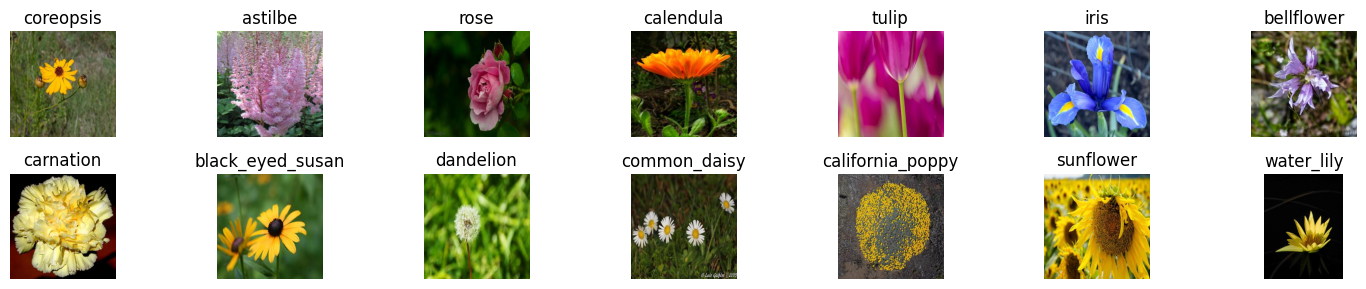

In [7]:
# plot gambar sampel untuk setiap kelas

# Path ke dataset
dataset_path = "dataset"

# Membuat dictionary untuk menyimpan daftar gambar di tiap kelas
image_dict = {}
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        image_dict[category] = os.listdir(category_path)

num_classes = len(image_dict)

rows = 2
cols = int(num_classes / rows)

fig, axs = plt.subplots(rows, cols, figsize=(15,3))

axs = axs.flatten()

for i, class_name in enumerate(image_dict):
    # Ambil 1 gambar acak
    image_name = np.random.choice(image_dict[class_name])
    img_path = os.path.join(dataset_path, class_name, image_name)
    img = Image.open(img_path).convert("RGB")

    axs[i].imshow(img)
    axs[i].set_title(class_name)
    axs[i].axis("off")

fig.tight_layout()
plt.show()

In [8]:
# mengecek resolusi gambar pada dataset

def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

print_images_resolution(dataset_path)

coreopsis: 1042
- (256, 256)
---------------
astilbe: 733
- (256, 256)
---------------
rose: 993
- (256, 256)
---------------
calendula: 1018
- (256, 256)
---------------
tulip: 1041
- (256, 256)
---------------
iris: 1048
- (256, 256)
---------------
bellflower: 879
- (256, 256)
---------------
carnation: 931
- (256, 256)
---------------
black_eyed_susan: 993
- (256, 256)
---------------
dandelion: 1045
- (256, 256)
---------------
common_daisy: 985
- (256, 256)
---------------
california_poppy: 1028
- (256, 256)
---------------
sunflower: 1020
- (256, 256)
---------------
water_lily: 984
- (799, 484)
- (800, 791)
- (799, 548)
- (799, 438)
- (799, 502)
- (800, 501)
- (800, 620)
- (799, 630)
- (800, 400)
- (800, 519)
- (800, 638)
- (800, 702)
- (800, 528)
- (800, 647)
- (800, 711)
- (800, 656)
- (799, 532)
- (799, 239)
- (799, 541)
- (531, 800)
- (799, 550)
- (750, 600)
- (799, 495)
- (799, 614)
- (800, 549)
- (799, 559)
- (800, 558)
- (800, 677)
- (571, 799)
- (800, 567)
- (800, 448)


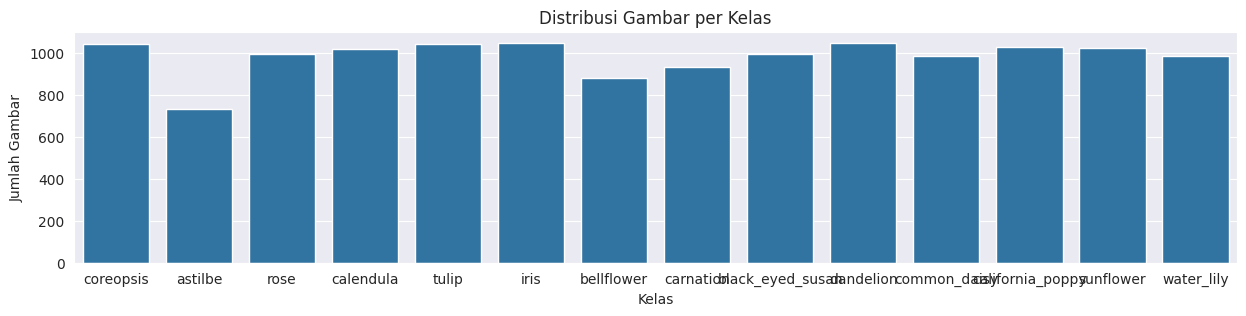

In [9]:
# plot distribusi gambar di seluruh kelas

# Buat list kosong untuk simpan info
file_name = []
labels = []
full_path = []

# Loop semua gambar dan ambil info
for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))  # ambil nama folder terakhir (label)
        file_name.append(name)

# Buat DataFrame
pizza_df = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Plot distribusi jumlah gambar per kelas
plt.figure(figsize=(15,3))
sns.set_style("darkgrid")
sns.countplot(x=pizza_df['labels'])
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.show()

### Data Preprocessing

#### Split Dataset

In [10]:
# ambil path dan label
data = []

for label in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, label)
    for img_file in os.listdir(class_path):
        data.append({
            "filepath": os.path.join(class_path, img_file),
            "label": label
        })

df = pd.DataFrame(data)

# split: 80% train, 10% val, 10% test
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42
)

In [11]:
# menampilkan jumlah label di setiap subset
print("Train set:")
print(train_df['label'].value_counts())
print("\nValidation set:")
print(val_df['label'].value_counts())
print("\nTest set:")
print(test_df['label'].value_counts())

Train set:
label
iris                839
dandelion           836
coreopsis           834
tulip               833
california_poppy    823
sunflower           816
calendula           814
black_eyed_susan    794
rose                794
common_daisy        788
water_lily          787
carnation           745
bellflower          703
astilbe             586
Name: count, dtype: int64

Validation set:
label
tulip               104
iris                104
coreopsis           104
dandelion           104
calendula           102
california_poppy    102
sunflower           102
black_eyed_susan    100
water_lily           99
rose                 99
common_daisy         99
carnation            93
bellflower           88
astilbe              74
Name: count, dtype: int64

Test set:
label
iris                105
dandelion           105
tulip               104
coreopsis           104
california_poppy    103
sunflower           102
calendula           102
rose                100
black_eyed_susan     99
com

#### Data Augmentation

In [12]:
datagen = ImageDataGenerator()

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),  # Gambar akan diresize ke 256x256
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),  # Gambar akan diresize ke 256x256
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 10992 validated image filenames belonging to 14 classes.
Found 1374 validated image filenames belonging to 14 classes.
Found 1374 validated image filenames belonging to 14 classes.


In [13]:
gc.collect()

4117

## Modelling

In [14]:
# Base model
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Model Sequential
model = Sequential()
model.add(base_model)

# Tambahan layer Conv2D setelah base_model
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(14, activation='softmax'))

# Summary
model.summary()

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       553,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │         8,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,557,454 (13.57 MB)

 Trainable params: 561,102 (2.14 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [15]:
# model compile
model.compile(
    optimizer ='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [16]:
# callbacks

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_acc',
    patience = 3,
    verbose = 1,
    factor = 0.5,
    min_lr = 0.00001)

checkpoint = ModelCheckpoint(
    "best_model.h5",
    save_best_only=True)

early_stopping = EarlyStopping(
    patience=20,
    restore_best_weights=True)

In [17]:
# training model
history = model.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
    callbacks=[reduce_lr, checkpoint, early_stopping])

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5565 - loss: 1.9515

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


344/344 ━━━━━━━━━━━━━━━━━━━━ 52s 110ms/step - accuracy: 0.5569 - loss: 1.9491 - val_accuracy: 0.8632 - val_loss: 0.4789 - learning_rate: 0.0010
Epoch 2/40
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8672 - loss: 0.4262

344/344 ━━━━━━━━━━━━━━━━━━━━ 59s 65ms/step - accuracy: 0.8673 - loss: 0.4261 - val_accuracy: 0.8988 - val_loss: 0.3656 - learning_rate: 0.0010
Epoch 3/40
344/344 ━━━━━━━━━━━━━━━━━━━━ 43s 72ms/step - accuracy: 0.9162 - loss: 0.2711 - val_accuracy: 0.8996 - val_loss: 0.3948 - learning_rate: 0.0010
Epoch 4/40
343/344 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9374 - loss: 0.1888

344/344 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - accuracy: 0.9374 - loss: 0.1889 - val_accuracy: 0.8974 - val_loss: 0.3457 - learning_rate: 0.0010
Epoch 5/40
344/344 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.9513 - loss: 0.1550 - val_accuracy: 0.9054 - val_loss: 0.3866 - learning_rate: 0.0010
Epoch 6/40
344/344 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.9536 - loss: 0.1535 - val_accuracy: 0.9017 - val_loss: 0.3983 - learning_rate: 0.0010
Epoch 7/40
344/344 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.9601 - loss: 0.1340 - val_accuracy: 0.9098 - val_loss: 0.3663 - learning_rate: 0.0010
Epoch 8/40
344/344 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - accuracy: 0.9604 - loss: 0.1356 - val_accuracy: 0.9039 - val_loss: 0.4084 - learning_rate: 0.0010
Epoch 9/40
344/344 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.9663 - loss: 0.1172 - val_accuracy: 0.9083 - val_loss: 0.4322 - learning_rate: 0.0010
Epoch 10/40
344/344 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9632 - loss: 0.128

## Evaluasi dan Visualisasi

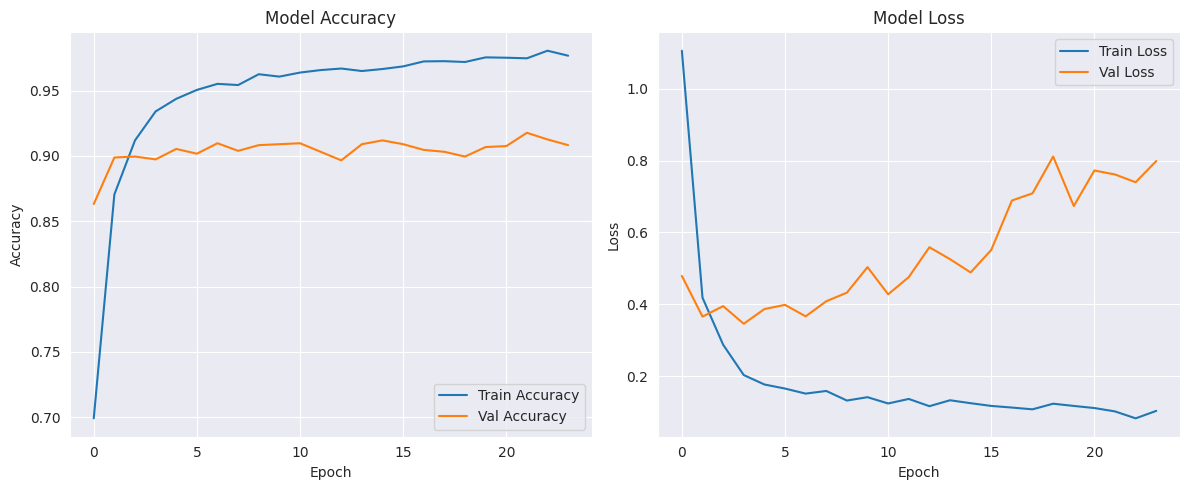

In [18]:
plt.figure(figsize=(12, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [19]:
# Evaluasi model pada data test
test_loss, test_accuracy = model.evaluate(test_generator)

# Menampilkan hasil evaluasi terhadap data test
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9126 - loss: 0.3009
Test Loss: 0.32366928458213806
Test Accuracy: 0.9090247750282288


## Konversi Model

In [20]:
# menyimpan model dalam format SavedModel
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

In [22]:
label_names = list(train_generator.class_indices.keys())
print(label_names)

['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'dandelion', 'iris', 'rose', 'sunflower', 'tulip', 'water_lily']


In [24]:
# menyimpan model dalam format tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

os.makedirs('tflite', exist_ok=True)
with open('tflite/model.tflite', 'wb') as f:
    f.write(converter.convert())

# membuat file label.txt dari class_names
with open('tflite/label.txt', 'w') as f:
    for label in label_names:
        f.write(f"{label}\n")

Saved artifact at '/tmp/tmpzwy5_5ws'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_203')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  133830722028176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133830790517328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133830790517904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133830790514832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133830790516560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133832523758288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133830790516368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133830790528464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133830722028368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133830722027792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133830790

In [29]:
# menyimpan model dalam format TensorFlow.js
os.makedirs('tfjs_model', exist_ok=True)
tfjs.converters.save_keras_model(model, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


In [44]:
from google.colab import files

# Download Folder vegetable_model (save model)
!zip -r saved_model.zip saved_model
files.download('saved_model.zip')

# Download File TF-Lite
!zip -r tflite.zip tflite
files.download('tflite.zip')

# Download Folder tfjs_model
!zip -r tfjs_model.zip tfjs_model
files.download('tfjs_model.zip')

  adding: saved_model/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/variables/variables.index (deflated 76%)
  adding: saved_model/saved_model.pb (deflated 92%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: tflite/ (stored 0%)
  adding: tflite/model.tflite (deflated 7%)
  adding: tflite/label.txt (deflated 30%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard1of4.bin (deflated 6%)
  adding: tfjs_model/group1-shard2of4.bin (deflated 7%)
  adding: tfjs_model/group1-shard3of4.bin (deflated 7%)
  adding: tfjs_model/group1-shard4of4.bin (deflated 7%)
  adding: tfjs_model/model.json (deflated 96%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

In [42]:
# upload gambar yang ingin diprediksi
from google.colab import files
uploaded = files.upload()

Saving Screenshot 2025-04-26 175316.png to Screenshot 2025-04-26 175316.png


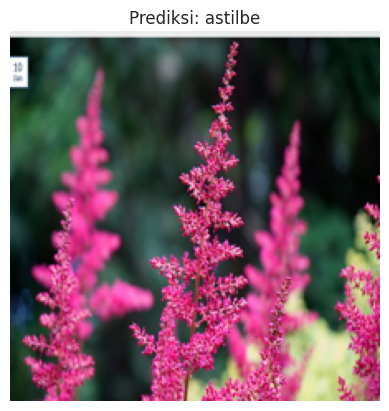

In [43]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Preprocessing sama kayak tadi
image_path = list(uploaded.keys())[0]
img = Image.open(image_path).convert('RGB')
img = img.resize((224,224))
img_array = np.array(img, dtype=np.float32) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()

# Ambil hasil output
output = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output)
predicted_label = label_names[predicted_class]

# Tampilkan gambar + prediksi
plt.imshow(img)
plt.title(f"Prediksi: {predicted_label}")
plt.axis('off')
plt.show()